# 0. Overview
This notebook ...  
   *//TO-DO*

# 1. Import data

In [ ]:
# INSTALL
#!pip install --user xgboost pyod imutils

In [62]:
import cv2
import matplotlib.pyplot as plt
import glob
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import imutils
from pyod.models.iforest import IForest
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.loda import LODA
from pyod.models.vae import VAE
from pyod.models.xgbod import XGBOD
from sklearn.model_selection import train_test_split

In [63]:
def quantify_image(image, bins=(4, 6, 3)):
    # compute a 3D color histogram over the image and normalize it
    hist = cv2.calcHist([image], [0, 1, 2], None, [16, 16, 16],
        [0, 256, 0, 256, 0, 256])
    hist = cv2.normalize(hist, hist).flatten()
    # return the histogram
    return hist

In [64]:
images=[]
features = []
PATH = 'GTSRB\Final_Training\Images'
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.ppm'))):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = imutils.resize(img, width=100)
    images.append(img)

100%|██████████████████████████████████████████████████████████████████████████| 39209/39209 [00:21<00:00, 1840.74it/s]


In [65]:
images = np.asarray(images)
images.shape

C:\Users\nbelh\AppData\Roaming\Python\Python37\site-packages\numpy\core\_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


(39209,)

In [66]:
labels = []
for filename in tqdm(glob.glob(os.path.join(PATH, '*\*.csv'))):
    labels.append(np.genfromtxt(filename, delimiter=';',skip_header=1,dtype='int32'))

100%|██████████████████████████████████████████████████████████████████████████████████| 43/43 [00:01<00:00, 37.14it/s]


In [67]:
labels = np.vstack(labels)[:,-1]
labels.shape

(39209,)

# 2. Combine data

In [68]:
all_data = np.column_stack((images,labels))

In [69]:
import pandas as pd

df = pd.DataFrame(data=all_data)
df = df.rename(columns={0: "ppm_image", df.columns[-1]: "label"})
df.tail()

,ppm_image,label
39204,"[[[13, 11, 12], [13, 11, 12], [11, 11, 12], [1...",42
39205,"[[[11, 9, 10], [11, 9, 10], [10, 9, 11], [10, ...",42
39206,"[[[10, 10, 12], [11, 11, 13], [12, 12, 14], [1...",42
39207,"[[[14, 13, 15], [14, 13, 15], [13, 13, 15], [1...",42
39208,"[[[10, 9, 11], [10, 9, 11], [10, 9, 11], [10, ...",42


In [70]:
df_stop = df[df.iloc[:,-1] == 14]
df_stop = df_stop.reset_index(drop=True)
df_stop.shape

(780, 2)

In [71]:
features = []
for img in df_stop['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)
df_stop = pd.concat([df_stop, pd.DataFrame(features)], axis=1)
df_stop.shape

(780, 4098)

# 3. Visualize data

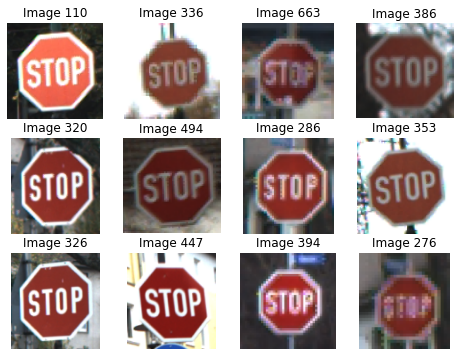

In [72]:
# Show a grid of MxN randomly selected samples from the training data

grid_m = 3
grid_n = 4
rand_grid = np.random.randint(df_stop.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(df_stop['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

In [73]:
df_train, df_test = train_test_split(df_stop, test_size=0.15)

print(df_train.shape)
print(df_test.shape)

(663, 4098)
(117, 4098)


In [74]:
df_outliers = df[df['label']==9].sample(10)
df_outliers = df_outliers.append(df[df['label']==17].sample(10))
df_outliers.reset_index(drop=True, inplace=True)
features = []
for img in df_outliers['ppm_image']:
    features.append(quantify_image(img))
features = np.asarray(features)

df_outliers = pd.concat([df_outliers, pd.DataFrame(features)], axis=1)
df_outliers.shape

(20, 4098)

In [75]:
df_test = df_test.append(df_outliers)
df_test.shape

(137, 4098)

In [54]:
df_train.head()

,ppm_image,label,0,1,2,3,4,5,6,7,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
687,"[[[73, 56, 50], [76, 52, 46], [48, 40, 35], [3...",14,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
473,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",14,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00059,0.00059,0.007669,0.053683,0.971611
707,"[[[95, 104, 150], [118, 121, 173], [114, 111, ...",14,0.0,0.1272,0.007067,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000
414,"[[[87, 79, 109], [100, 74, 91], [72, 62, 62], ...",14,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.267552
391,"[[[65, 59, 65], [66, 61, 66], [68, 64, 68], [6...",14,0.0,0.0000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.000000,0.000000,0.000000


# 1. Isolation Forest

In [76]:
# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
model = IForest(n_estimators=100, contamination=0.1, n_jobs=-1, random_state=42)
model.fit(df_train.iloc[:,2:])

[INFO] fitting anomaly detection model...


IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=-1, random_state=42,
    verbose=0)

In [77]:
preds = model.predict(df_test.iloc[:,2:])
preds

array([0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0])

In [79]:
df_test.iloc[:,[0,1]][preds==1]

,ppm_image,label
541,"[[[211, 174, 131], [211, 174, 131], [176, 151,...",14
140,"[[[58, 62, 54], [62, 67, 61], [63, 69, 62], [6...",14
134,"[[[34, 42, 38], [34, 42, 38], [34, 42, 38], [3...",14
467,"[[[255, 248, 255], [253, 247, 253], [247, 242,...",14
143,"[[[77, 93, 82], [85, 98, 90], [76, 84, 77], [6...",14
676,"[[[56, 62, 62], [56, 62, 64], [56, 62, 75], [5...",14
545,"[[[230, 190, 143], [230, 190, 143], [204, 175,...",14
548,"[[[119, 147, 126], [121, 148, 128], [166, 174,...",14
64,"[[[213, 245, 220], [213, 245, 220], [214, 244,...",14
420,"[[[255, 213, 206], [255, 213, 206], [255, 222,...",14


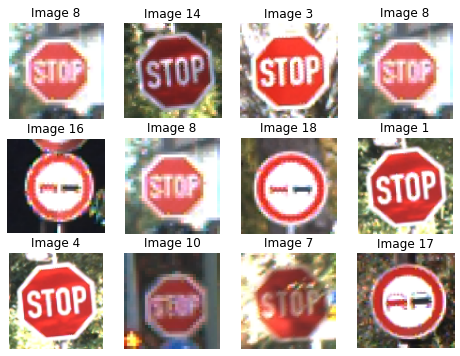

In [78]:
iforest_res = df_test.iloc[:,[0,1]][preds==1].reset_index(drop=True)
rand_grid = np.random.randint(iforest_res.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(iforest_res['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

# 2. Auto Encoders

In [80]:
# train the anomaly detection model
print("[INFO] fitting anomaly detection model...")
model = AutoEncoder(epochs=10, random_state=42)
model.fit(df_train.iloc[:,2:])

[INFO] fitting anomaly detection model...
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_18 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_22 (Dense)             (None, 4096)              16781312  
_________________________________________________________________
dropout_19 (Dropout)         (None, 4096)              0         
_________________________________________________________________
dense_23 (Dense)             (None, 64)                262208    
_________________________________________________________________
dropout_20 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_24 (De

AutoEncoder(batch_size=32, contamination=0.1, dropout_rate=0.2, epochs=10,
      hidden_activation='relu', hidden_neurons=[64, 32, 32, 64],
      l2_regularizer=0.1,
      loss=<function mean_squared_error at 0x0000025998BE2168>,
      optimizer='adam', output_activation='sigmoid', preprocessing=True,
      random_state=42, validation_size=0.1, verbose=1)

In [81]:
preds = model.predict(df_test.iloc[:,2:])
df_test.iloc[:,[0,1]][preds==1]

,ppm_image,label
541,"[[[211, 174, 131], [211, 174, 131], [176, 151,...",14
140,"[[[58, 62, 54], [62, 67, 61], [63, 69, 62], [6...",14
134,"[[[34, 42, 38], [34, 42, 38], [34, 42, 38], [3...",14
467,"[[[255, 248, 255], [253, 247, 253], [247, 242,...",14
252,"[[[255, 255, 255], [255, 255, 255], [255, 255,...",14
676,"[[[56, 62, 62], [56, 62, 64], [56, 62, 75], [5...",14
545,"[[[230, 190, 143], [230, 190, 143], [204, 175,...",14
548,"[[[119, 147, 126], [121, 148, 128], [166, 174,...",14
64,"[[[213, 245, 220], [213, 245, 220], [214, 244,...",14
420,"[[[255, 213, 206], [255, 213, 206], [255, 222,...",14


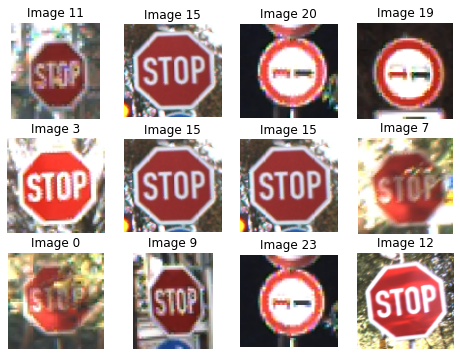

In [82]:
ae_res = df_test.iloc[:,[0,1]][preds==1].reset_index(drop=True)
rand_grid = np.random.randint(ae_res.shape[0], size=[grid_m,grid_n])

f0, cell0 = plt.subplots(grid_m, grid_n, figsize=(8,6))
for i in range(grid_m):
    for j in range(grid_n):
        cell0[i, j].imshow(ae_res['ppm_image'][rand_grid[i,j]])
        cell0[i, j].axis('off')
        cell0[i, j].set_title('Image {}'.format(rand_grid[i,j]))

# 3. LODA